# Network Intrusion Detection Using Artificial Intelligence
Intrusion detection Systems (IDS) are crucial for identifying and mitigating potential threats to computer networks. With the increasing complexity of cyber-attacks, traditional rule-based systems are often insufficient. This project aims to leverage machine learning techniques to enhance the detection capabilities of IDS, focusing on the CIC-IDS2017 dataset, which contains a wide range of network traffic data, including benign and malicious activities. By applying various machine learning algorithms, we aim to improve the accuracy and efficiency of intrusion detection systems, ultimately contributing to a more secure digital environment.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pathlib
from sklearn.preprocessing import LabelEncoder


In [148]:
!ls

final-model.ipynb
Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
Friday-WorkingHours-Morning.pcap_ISCX.csv
Monday-WorkingHours.pcap_ISCX.csv
Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
Tuesday-WorkingHours.pcap_ISCX.csv
Wednesday-workingHours.pcap_ISCX.csv


## Data Loading
I am loading the dataset from the csv files in the current directory. The dataset is a collection of CSV files that contain network traffic data, including both benign and malicious activities. The goal is to read all the CSV files and concatenate them into a single dataframe for further analysis and modeling.

In [197]:
"""
Reading all the csv files and concatenating them into a single dataframe
"""
# Read the CSV files
csv_files = list(pathlib.Path('.').glob('*.csv'))
csv_files.sort(key=lambda x: x.name)
csv_files

[PosixPath('Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'),
 PosixPath('Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv'),
 PosixPath('Friday-WorkingHours-Morning.pcap_ISCX.csv'),
 PosixPath('Monday-WorkingHours.pcap_ISCX.csv'),
 PosixPath('Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv'),
 PosixPath('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv'),
 PosixPath('Tuesday-WorkingHours.pcap_ISCX.csv'),
 PosixPath('Wednesday-workingHours.pcap_ISCX.csv')]

In [198]:
dataframes = [pd.read_csv(file) for file in csv_files]
df = pd.concat(dataframes, ignore_index=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


## Data Preprocessing

here i will be checking the data types and null values also i will be checking the unique values
and the distribution of the data and removing the infinite values.
- Checking the data types
- Checking the null values
- Checking the unique values
- Checking the distribution of the data
- Removing the infinite values
- Checking the distribution of the data
All thse steps are important to understand the data and to prepare it for the model

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2830743 entries, 0 to 2830742
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

> We have about 78 columns and 2830742 rows  in the dataset which most of them are numbers (Hence and already engineered)

In [152]:
df.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,...,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06,2.830743e+06
mean,8.071483e+03,1.478566e+07,9.361160e+00,1.039377e+01,5.493024e+02,1.616264e+04,2.075999e+02,1.871366e+01,5.820194e+01,6.891013e+01,...,5.418218e+00,-2.741688e+03,8.155132e+04,4.113412e+04,1.531825e+05,5.829582e+04,8.316037e+06,5.038439e+05,8.695752e+06,7.920031e+06
std,1.828363e+04,3.365374e+07,7.496728e+02,9.973883e+02,9.993589e+03,2.263088e+06,7.171848e+02,6.033935e+01,1.860912e+02,2.811871e+02,...,6.364257e+02,1.084989e+06,6.485999e+05,3.933815e+05,1.025825e+06,5.770923e+05,2.363008e+07,4.602984e+06,2.436689e+07,2.336342e+07
min,0.000000e+00,-1.300000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,-5.368707e+08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.300000e+01,1.550000e+02,2.000000e+00,1.000000e+00,1.200000e+01,0.000000e+00,6.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.000000e+01,3.131600e+04,2.000000e+00,2.000000e+00,6.200000e+01,1.230000e+02,3.700000e+01,2.000000e+00,3.400000e+01,0.000000e+00,...,1.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,3.204828e+06,5.000000e+00,4.000000e+00,1.870000e+02,4.820000e+02,8.100000e+01,3.600000e+01,5.000000e+01,2.616295e+01,...,2.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.200000e+08,2.197590e+05,2.919220e+05,1.290000e+07,6.554530e+08,2.482000e+04,2.325000e+03,5.940857e+03,7.125597e+03,...,2.135570e+05,1.380000e+02,1.100000e+08,7.420000e+07,1.100000e+08,1.100000e+08,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


> Looking at column statistics we can see that most of the columns are numerical and some of them are categorical

In [200]:
df['Label'] = df[' Label']
df.drop([' Label'], axis=1, inplace=True)
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


> The Label column is the only categorical column in the dataset

In [201]:
df['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

> The Label column has 17 unique values which are the labels we are going to predict

In [156]:
df['Label'].value_counts()

Label
BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

/opt/anaconda3/envs/AI2025-2/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


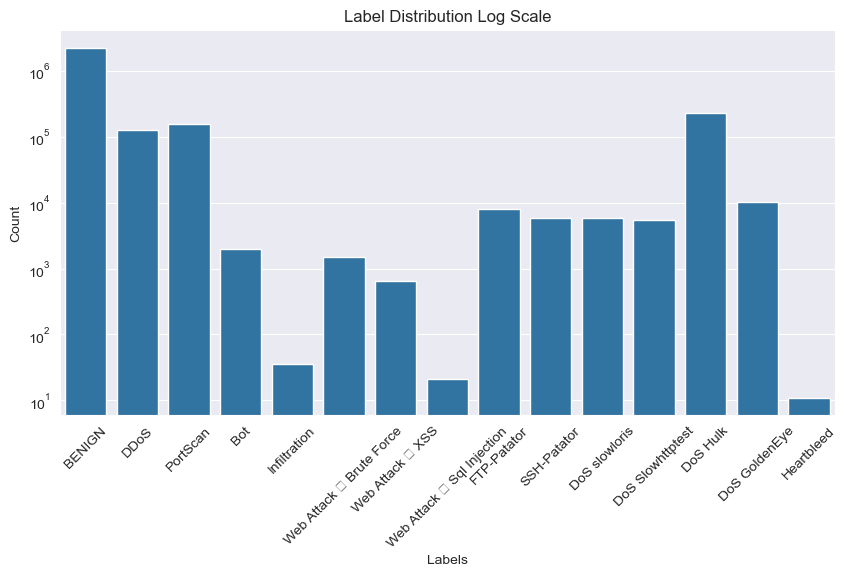

In [207]:
plt.figure(figsize=(10, 5))
# plt.hist(df['Label'].value_counts())
sns.countplot(x='Label', data=df)
plt.title('Label Distribution Log Scale')
plt.yscale('log')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

> The above plot shows the distribution of the labels in the dataset

In [157]:
df = df.dropna(subset=['Label']) # Drop columns with all NaN values
df['Label'].unique()

array(['BENIGN', 'DDoS', 'PortScan', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS Hulk', 'DoS GoldenEye',
       'Heartbleed'], dtype=object)

### Encoding the label column

In [158]:
# Encoding the label column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [159]:
df['Label'].unique()

array([ 0,  2, 10,  1,  9, 12, 14, 13,  7, 11,  6,  5,  4,  3,  8])

### Checking Missing Values

In [160]:
df.isna().sum()

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
Label                          0
Length: 79, dtype: int64

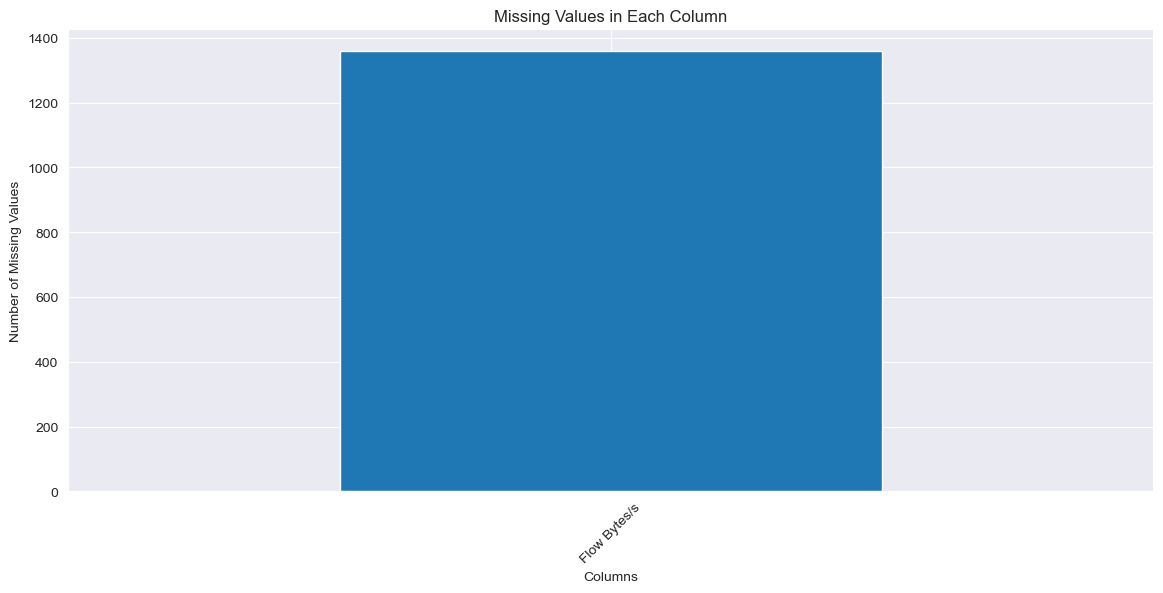

In [161]:
missing_counts = df.isna().sum()
missing_counts = missing_counts[missing_counts > 0]

# Plotting the missing values
plt.figure(figsize=(14, 6))
missing_counts.plot(kind='bar')
plt.title('Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45)
plt.show()

> The are some missing values in the dataset

Removing the missing values and replacing the infinite values with NaN. These steps are important to prepare the data for the model

In [163]:
# Dropping the infinite values and NaN values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df.isna().sum()

 Destination Port              0
 Flow Duration                 0
 Total Fwd Packets             0
 Total Backward Packets        0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
 Idle Std                      0
 Idle Max                      0
 Idle Min                      0
Label                          0
Length: 79, dtype: int64

In [164]:
sorted(df.max())

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 14.0,
 138.0,
 156.0,
 1448.0,
 2325.0,
 2896.0,
 3337.142857,
 3893.333333,
 4731.522394,
 5800.5,
 5800.5,
 5940.857143,
 5940.857143,
 7125.5968458437,
 8194.660487,
 19530.0,
 24820.0,
 24820.0,
 65535.0,
 65535.0,
 65535.0,
 213557.0,
 219759.0,
 219759.0,
 291922.0,
 291922.0,
 2000000.0,
 3000000.0,
 4000000.0,
 4644908.0,
 4644908.0,
 5838440.0,
 12870338.0,
 12900000.0,
 22400000.0,
 74200000.0,
 76900000.0,
 84418013.7826341,
 84602929.2769822,
 84800261.5664079,
 110000000.0,
 110000000.0,
 110000000.0,
 119999998.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 120000000.0,
 655453030.0,
 655453030.0,
 2071000000.0]

### Scaling and Train-Test Split

In [186]:
X = df.drop(['Label'], axis=1)
y = df['Label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
len(X_train), len(X_test), len(y_train), len(y_test)

(2262300, 565576, 2262300, 565576)

## Training the Model
in this section i will be training the model using the RandomForestClassifier, LogisticRegression, DecisionTree Classifier and the Neural Network

I will also be evaluating the model using the classification report and confusion matrix and accuracy score


### Random Forest Classifier model
this is the first model i will be using to train the data and predict the labels, the random forest classifier is a supervised learning algorithm that is used for classification and regression tasks. It works by creating a forest of decision trees and combining their predictions to improve accuracy and reduce overfitting.

In [166]:
# Model Prediction
from sklearn.ensemble import RandomForestClassifier
import time

start_time = time.time()
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
end_time = time.time()

Confusion matrix and classification report are used to evaluate the performance of the model. The confusion matrix shows the number of true positive, true negative, false positive and false negative predictions. The classification report shows the precision, recall and f1 score of the model.

In [167]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
preds = rfc.predict(X_test)
print(f'The accuracy of the model is {round(accuracy_score(y_test, preds))} With training time of {round(end_time - start_time, 2)} seconds')
print(classification_report(y_test, preds))

The accuracy of the model is 1 With training time of 426.23 seconds
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    454089
           1       0.91      0.69      0.79       386
           2       1.00      1.00      1.00     25588
           3       1.00      1.00      1.00      2055
           4       1.00      1.00      1.00     46259
           5       0.99      0.99      0.99      1103
           6       1.00      1.00      1.00      1146
           7       1.00      1.00      1.00      1570
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5
          10       0.99      1.00      0.99     31712
          11       1.00      1.00      1.00      1242
          12       0.74      0.83      0.78       291
          13       1.00      0.20      0.33         5
          14       0.41      0.25      0.31       122

    accuracy                           1.00    565576
   macro avg

Confusion Matrix Plot for Random Forest Classifier model

/opt/anaconda3/envs/AI2025-2/lib/python3.13/site-packages/seaborn/utils.py:61: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from font(s) Arial.
  fig.canvas.draw()
/opt/anaconda3/envs/AI2025-2/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65533 (\N{REPLACEMENT CHARACTER}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


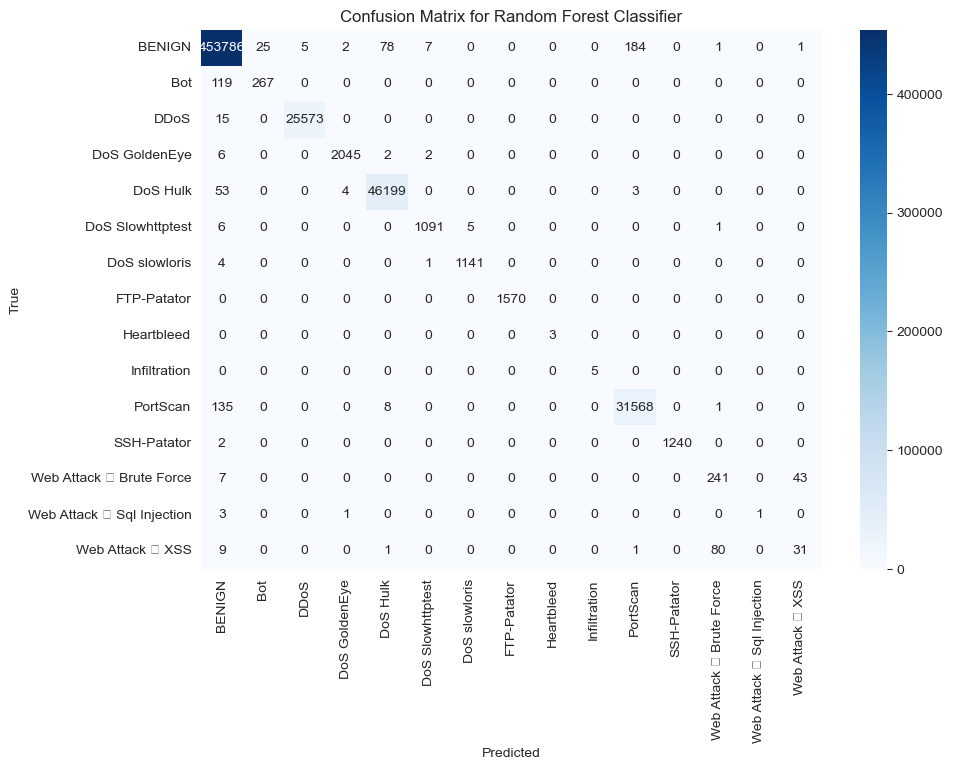

In [169]:
cm_rf = confusion_matrix(y_test, preds)
labels = le.inverse_transform(np.unique(y_test))
plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### Logistic Regression and Decision Tree Classifier
Logistic Regression is a statistical method for predicting binary classes. The outcome is usually a binary variable (0/1, True/False, Yes/No). It uses the logistic function to model a binary dependent variable.
Decision Tree Classifier is a supervised learning algorithm that is used for classification and regression tasks. It works by splitting the data into subsets based on the value of the input features. The splits are made based on the feature that provides the most information gain or the least impurity.

The importance of these models is that they are easy to interpret and visualize. They can handle both numerical and categorical data. They are also robust to outliers and can handle missing values. However, they can be prone to overfitting if the tree is too deep or if there are too many features.

In [187]:
# Testing with other models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


tree = DecisionTreeClassifier()
logreg = LogisticRegression()

for model in [logreg, tree]:
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(model.__class__.__name__, accuracy_score(y_test, preds))
    # print(model.__class__.__name__, confusion_matrix(y_test, preds))
    print(model.__class__.__name__, classification_report(y_test, preds))

/opt/anaconda3/envs/AI2025-2/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression 0.967599403086411
LogisticRegression               precision    recall  f1-score   support

           0       0.99      0.97      0.98    454089
           1       0.18      0.01      0.02       386
           2       0.99      0.96      0.98     25588
           3       0.89      0.86      0.88      2055
           4       0.92      0.96      0.94     46259
           5       0.81      0.83      0.82      1103
           6       0.88      0.52      0.66      1146
           7       0.92      0.54      0.68      1570
           8       0.00      0.00      0.00         3
           9       0.00      0.00      0.00         5
          10       0.81      1.00      0.89     31712
          11       0.69      0.07      0.14      1242
          12       0.00      0.00      0.00       291
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00       122

    accuracy                           0.97    565576
   macro avg       0.54 

/opt/anaconda3/envs/AI2025-2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/AI2025-2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/AI2025-2/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

DecisionTreeClassifier 0.9984016294892287
DecisionTreeClassifier               precision    recall  f1-score   support

           0       1.00      1.00      1.00    454089
           1       0.82      0.81      0.82       386
           2       1.00      1.00      1.00     25588
           3       1.00      1.00      1.00      2055
           4       1.00      1.00      1.00     46259
           5       0.98      0.99      0.99      1103
           6       0.99      0.99      0.99      1146
           7       1.00      1.00      1.00      1570
           8       1.00      1.00      1.00         3
           9       1.00      1.00      1.00         5
          10       0.99      0.99      0.99     31712
          11       1.00      1.00      1.00      1242
          12       0.76      0.77      0.76       291
          13       0.75      0.60      0.67         5
          14       0.43      0.40      0.41       122

    accuracy                           1.00    565576
   macro avg   

### Neural Network Model
The neural network model is a supervised learning algorithm that is used for classification and regression tasks. It works by creating a network of neurons that are connected to each other. The neurons are organized into layers, with each layer performing a specific function. The input layer receives the input data, the hidden layers perform computations on the data, and the output layer produces the final output.

With neural network model it helps to learn complex patterns in the data and can handle large amounts of data. It is also robust to noise and can handle missing values. However, it can be prone to overfitting if the network is too deep or if there are too many features. It also requires a lot of computational power and time to train the model.

In [170]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Fitness function definition


I have created a function called fit that takes the model, optimizer, criterion, epochs, train_dataloader and val_dataloader as input parameters. The function trains the model using the given parameters and returns the trained model.
The function first sets the model to training mode and then iterates over the number of epochs. For each epoch, it iterates over the training dataloader and performs the following steps:
1. Zero the gradients of the optimizer
2. Perform a forward pass of the model
3. Calculate the loss using the criterion
4. Perform a backward pass of the model
5. Evaluate the model using the validation dataloader
6. Calculate the accuracy of the model
7. Print the loss and accuracy of the model
8. Append the loss to the train_losses and test_losses lists

In [194]:
def fit(model,
        optimizer,
        criterion=nn.CrossEntropyLoss(),
        epochs=5,
        train_dataloader=None,
        val_dataloader=None):
    """
    Train the model with the given parameters.
    Args:
        model (nn.Module): The model to train.
        optimizer (torch.optim.Optimizer): The optimizer to use.
        criterion (nn.Module): The loss function to use.
        epochs (int): Number of epochs to train for.
        train_dataloader (DataLoader): DataLoader for training data.
        val_dataloader (DataLoader): DataLoader for validation data.
    """
    optimizer = optim.Adam(model.parameters(), lr=0.001) if optimizer is None else optimizer
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * inputs.size(0)  # Accumulate weighted loss

        epoch_loss /= len(train_dataloader.dataset)  # Average loss
        # print(f'Epoch [{epoch+1}/{len(epochs)}], Loss: {epoch_loss:.4f}')
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.argmax(outputs, dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss /= len(val_dataloader.dataset)
        accuracy = correct / total
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {epoch_loss:.4f}, Test Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
        train_losses.append(epoch_loss)
        test_losses.append(val_loss)
    return train_

In [195]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Batch size
batch_size = 32

# tensor datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Definition
model = SimpleNN(input_size=X_train.shape[1], hidden_size=32, output_size=len(le.classes_))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Fit the function
fit(model=model,
    optimizer=optimizer,
    criterion=criterion,
    epochs=5,
    train_dataloader=train_loader,
    val_dataloader=test_loader)


Epoch [1/5], Train Loss: 0.0695, Test Loss: 0.0505, Accuracy: 0.9786
Epoch [2/5], Train Loss: 0.0482, Test Loss: 0.0431, Accuracy: 0.9830
Epoch [3/5], Train Loss: 0.0417, Test Loss: 0.0385, Accuracy: 0.9887
Epoch [4/5], Train Loss: 0.0356, Test Loss: 0.0302, Accuracy: 0.9909
Epoch [5/5], Train Loss: 0.0305, Test Loss: 0.0270, Accuracy: 0.9912


## Dimensionality Reduction

In [177]:
# Using PCA
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_tensor_pca = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_tensor_pca = torch.tensor(X_test_pca, dtype=torch.float32)
y_train_tensor_pca = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor_pca = torch.tensor(y_test.values, dtype=torch.long)

train_dataset_pca = TensorDataset(X_train_tensor_pca, y_train_tensor_pca)
test_dataset_pca = TensorDataset(X_test_tensor_pca, y_test_tensor_pca)

train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

model_pca = SimpleNN(input_size=X_train_pca.shape[1], hidden_size=32, output_size=len(le.classes_))
criterion_pca = nn.CrossEntropyLoss()
optimizer_pca = optim.Adam(model_pca.parameters(), lr=0.001)

train_losses = []
test_losses = []

for epoch in range(5):
    model_pca.train()
    for inputs, labels in train_loader_pca:
        optimizer_pca.zero_grad()
        outputs = model_pca(inputs)
        loss = criterion_pca(outputs, labels)
        loss.backward()
        optimizer_pca.step()
        train_losses.append(loss.item())

    model_pca.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader_pca:
            outputs = model_pca(inputs)
            loss = criterion_pca(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader_pca.dataset)
    test_losses.append(test_loss)
    accuracy = correct / total

    print(f"Epoch [{epoch+1}/5], Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/5], Test Loss: 0.0519, Accuracy: 0.9785
Epoch [2/5], Test Loss: 0.0443, Accuracy: 0.9817
Epoch [3/5], Test Loss: 0.0388, Accuracy: 0.9829
Epoch [4/5], Test Loss: 0.0334, Accuracy: 0.9900
Epoch [5/5], Test Loss: 0.0314, Accuracy: 0.9901


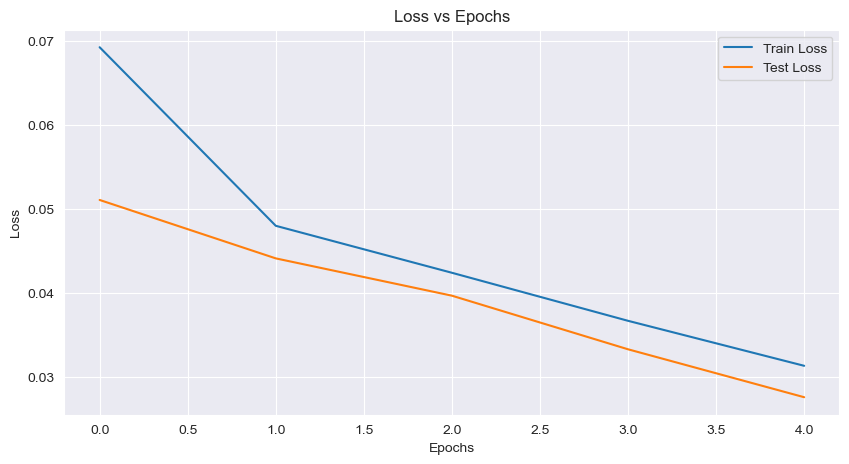

In [174]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

> The plot for the loss vs epochs shows that the model is learning and the loss is decreasing over the epochs. both the train and test loss are decreasing which indicates that the model is learning and not overfitting. The model is able to generalize well on the test data.

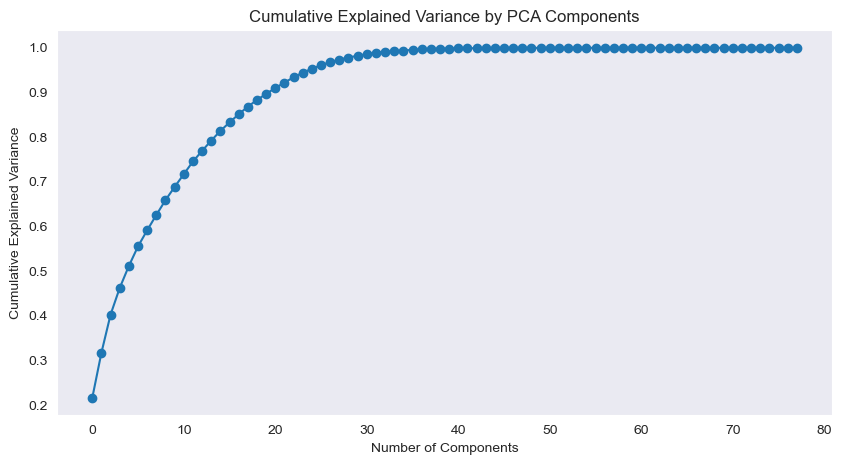

In [178]:
pca_full = PCA()
pca_full.fit(X_train)

explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [182]:
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_95

np.int64(25)

> The number of components to retain 95% of the variance is 25

### Using PCA with 95% variance
In this section i will be using PCA to reduce the dimensionality of the data and then train the model using the reduced data. I will be using the same model as before and will be evaluating the model using the accuracy.

In [183]:
# Using PCA
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

X_train_tensor_pca = torch.tensor(X_train_pca, dtype=torch.float32)
X_test_tensor_pca = torch.tensor(X_test_pca, dtype=torch.float32)
y_train_tensor_pca = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor_pca = torch.tensor(y_test.values, dtype=torch.long)

train_dataset_pca = TensorDataset(X_train_tensor_pca, y_train_tensor_pca)
test_dataset_pca = TensorDataset(X_test_tensor_pca, y_test_tensor_pca)

train_loader_pca = DataLoader(train_dataset_pca, batch_size=batch_size, shuffle=True)
test_loader_pca = DataLoader(test_dataset_pca, batch_size=batch_size, shuffle=False)

model_pca = SimpleNN(input_size=X_train_pca.shape[1], hidden_size=32, output_size=len(le.classes_))
criterion_pca = nn.CrossEntropyLoss()
optimizer_pca = optim.Adam(model_pca.parameters(), lr=0.001)

train_losses = []
test_losses = []

for epoch in range(5):
    model_pca.train()
    for inputs, labels in train_loader_pca:
        optimizer_pca.zero_grad()
        outputs = model_pca(inputs)
        loss = criterion_pca(outputs, labels)
        loss.backward()
        optimizer_pca.step()
        train_losses.append(loss.item())

    model_pca.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader_pca:
            outputs = model_pca(inputs)
            loss = criterion_pca(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss /= len(test_loader_pca.dataset)
    test_losses.append(test_loss)
    accuracy = correct / total

    print(f"Epoch [{epoch+1}/5], Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")

Epoch [1/5], Test Loss: 0.0617, Accuracy: 0.9753
Epoch [2/5], Test Loss: 0.0568, Accuracy: 0.9772
Epoch [3/5], Test Loss: 0.0556, Accuracy: 0.9758
Epoch [4/5], Test Loss: 0.0519, Accuracy: 0.9792
Epoch [5/5], Test Loss: 0.0527, Accuracy: 0.9789
